In [94]:
import numpy as np
# skylearn for datasets --> use for future ref
from sklearn import datasets
# scipy.special for the sigmoid function expit(), and its inverse logit()
import scipy.special 
# library for network analysis
import networkx as nx
# library for plotting arrays
import matplotlib.pyplot as plt
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

In [95]:
class NeuralNetwork(object):
    # Class to create a simple fully connect NN model containing
    #    1 hidden layer
    #    sigmoid function activation function  
    # Input: - Number of input nodes
    #        - Number of hidden nodes
    #        - Number of output nodes
    #        - Learning Rate
    def __init__(self,inputnodes,hiddennodes,outputnodes,learningRate=0.1):
        # Initialize number of nodes
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        # Initialize random weights
        self.wih = np.random.normal(0.00,np.power(self.inodes,-0.5),(self.hnodes,self.inodes))
        self.who = np.random.normal(0.00,np.power(self.hnodes,-0.5),(self.onodes,self.hnodes))
        # Set Learning rate
        self.LR = learningRate
        # Initialize Activation Function
        self.activationfunction   = lambda x: scipy.special.expit(x)
        self.i_activationfunction = lambda x: scipy.special.logit(x)
        # Initialize Loss
        self.Loss  = []
        # Initialize Graph components
        self.graph  = None
        self.adjmat = None
        return
    
    def train(self,inputs,targets): 
        ### FORWARD Propogation ###
        # input layer to hidden layer (regression + activation)         
        z_i1h1     = np.dot(self.wih,inputs)
        h1_est     = self.activationfunction(z_i1h1)
        
        # hidden layer to output layer (regression + activation)
        z_h1o     = np.dot(self.who,h1_est)
        out_est   = self.activationfunction(z_h1o)
        
        # Calculate MSE loss function => dLoss/dsig = -(y - ypred)
        JMSE = 0.5 * np.sum(np.power(out_est-targets,2))
        self.Loss.append(JMSE)
        
        ### BACKWARD Propogation ###
        # Calculate gradient of MSE loss function => dLoss/dsig = -(y - ypred)
        do_loss  = targets - out_est           # output weight errors
        dh1_loss = np.dot(self.who.T,do_loss)  # hidden layer weight errors
        
        # gradient of sigmoid activation function => dsig/dw = (1 - sig(z))sig(z)
        dActivationH = out_est * (1 - out_est)
        dActivationI = h1_est * (1 - h1_est)
        
        
        ## pdate weights ##
        #  Weight update Rule => w = w + LR * dL/dx
        #                         --> dL/dh = dLoss/dsig*dsig/dw*dw/dx
        #                             - dw/dx = x
        dLdh      = np.dot(do_loss * dActivationH,h1_est.T)
        self.who  += self.LR * dLdh
        
        # Inner Layer Weights 
        dLdx      = np.dot(dh1_loss * dActivationI,inputs.T)
        self.wih += self.LR * dLdx
        return
    
    def buildGraph(self):
        # Builds Adjacency matrix and graph from trained NN
        inodes = self.inodes
        hnodes = self.hnodes
        onodes = self.onodes
        
        # Create Adjacency matrix
        tot_nodes = inodes + hidden_nodes + onodes
        adj_mat   = np.zeros((tot_nodes,tot_nodes))
        
        # Normalize weights from NN model --> default scale (-1, 1)
        norm_wih = self.__featureScaling(self.wih)
        norm_who = self.__featureScaling(self.who)
        
        # Fill in Adj Mat
        adj_mat[:inodes,inodes:hnodes+inodes]        = norm_wih.T 
        adj_mat[inodes:inodes+hnodes,hnodes+inodes:] = norm_who.T 

        # Create graph from adjacency matrix
        G = nx.from_numpy_matrix(adj_mat)
        
        # Store results
        self.adj_mat = adj_mat
        self.graph   = G
        return
    def __featureScaling(self,inputs,scale = 1):
        # Scale input between srange {1}
        min_w  = np.amin(inputs)
        mean_w = np.mean(inputs)
        max_w  = np.amax(inputs)
        return scale * (inputs - min_w) / (max_w-min_w)
    
    def visualizeGraph(self,percentile=0.9):
        # Plot graph to visualize Neural Network
        tot_nodes = self.inodes + self.hnodes + self.onodes
        # Build graph if it hasn't already been built
        if self.graph is None:
            self.buildGraph()
        
        # Create Adjacency matrix
        
        # Normalize weights from NN model --> default scale = 1
        norm_wih = self.__featureScaling(self.wih)
        norm_who = self.__featureScaling(self.who)
        
        #Create Node Labels
        node_names =      ['I'+str(iN) for iN in np.arange(self.inodes)]
        node_names.extend(['H'+str(iN) for iN in np.arange(self.hnodes)])
        node_names.extend(['O'+str(iN) for iN in np.arange(self.onodes)])
        
        #Use model graph data
        G = self.graph
        G.edges(data=True)
        
        # Identify edges that have biggest effect on graph
        pos_edges     =[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >=percentile]
        neutral_edges =[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >(1- percentile) and d['weight'] < percentile]
        neg_edges     =[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=(1 - percentile)]
        
        # position nodes
        first  = np.array([np.arange(input_nodes),np.full(input_nodes,10)])
        second = np.array([np.linspace(0,input_nodes,num=hidden_nodes),np.full(hidden_nodes,5)])
        last   = np.array([np.linspace(0,input_nodes,num=output_nodes),np.full(output_nodes,0)])
        ndlist = np.hstack((first,second,last))
        
        # configure NN layers on graph
        pos = dict()
        for idx in range(tot_nodes):
            pos[idx] = ndlist[:,idx]

        # Resize nodes to fit their absolute influence
        inputNodeSize = np.sum(np.abs(norm_wih),axis=0)
        inputNodeSize = self.__featureScaling(inputNodeSize,scale= 100)

        hiddenNodeSize = np.sum(np.abs(norm_who),axis=0)
        hiddenNodeSize = self.__featureScaling(hiddenNodeSize,scale = 100)

        # draw nodes  
        nx.draw_networkx_nodes(G,pos,
                       nodelist=range(0, input_nodes),
                       node_color='b',
                       node_size=inputNodeSize, alpha=0.8)
        nx.draw_networkx_nodes(G,pos,
                       nodelist=range(input_nodes, (input_nodes+hidden_nodes)),
                       node_color='c',
                       node_size=hiddenNodeSize, alpha=0.8)  
        nx.draw_networkx_nodes(G,pos,
                       nodelist=range((input_nodes+hidden_nodes), tot_nodes),
                       node_color='k',
                       node_size=100, alpha=0.8)   
        # draw edges
        nx.draw_networkx_edges(G,pos,edgelist=pos_edges,
                    width=3,edge_color='g')
        nx.draw_networkx_edges(G,pos,edgelist=neg_edges,
                    width=1,edge_color='r')
        nx.draw_networkx_edges(G,pos,edgelist=neutral_edges,
                    width=0)
        # Relabel nodes
        name_mapping = dict(zip(G.nodes(), node_names))
        G=nx.relabel_nodes(G,name_mapping)
        # Show graph
        plt.axis("off")
        plt.show()
        return
    
    def predict(self,inputs): 
        # input layer to hidden layer (regression + activation)
        z_i1h1     = np.dot(self.wih,inputs)
        h1_est     = self.activationfunction(z_i1h1)
        
        # hidden layer to output layer (regression + activation)
        z_h1o     = np.dot(self.who,h1_est)
        out_est   = self.activationfunction(z_h1o)
        np.arange(0,9)
         
        return out_est
    

In [96]:
# load the mnist training data CSV file into a list
path = "/Users/maxmaguire/Desktop/PostGradWork/DataFolder/CSVFiles/"

training_data_file = open(path+"mnist_train_100.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# number of input, hidden and output nodes
input_nodes  = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learn_rate = 0.1

# create instance of neural network
NN2 = NeuralNetwork(input_nodes,hidden_nodes,output_nodes, learningRate=learn_rate)

# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 10

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        # Convert to correct dimensions
        inputs  = np.array(inputs, ndmin=2).T
        targets = np.array(targets, ndmin=2).T
        NN2.train(inputs, targets)
        pass
    pass

performance =  0.7


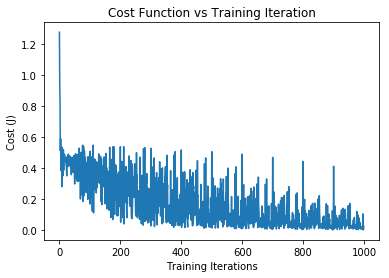

Jitter in Cost function can be due to optimization method: GD


In [97]:
# load the mnist test data CSV file into a list
test_data_file = open(path+"mnist_test_10.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale and shift the inputs
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = NN2.predict(inputs)
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass

# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)
# Visualize Cost function vs Iteration
plt.plot(NN2.Loss)
plt.title("Cost Function vs Training Iteration")
plt.xlabel('Training Iterations')
plt.ylabel("Cost (J)")
plt.show()
print("Jitter in Cost function can be due to optimization method: GD")

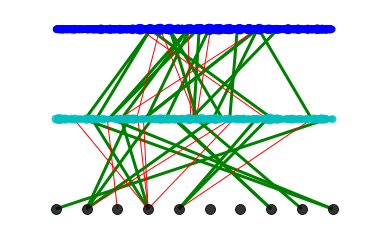

Graph intended to visualize structure of 3 Layered Fully connected Network
	- Input Layer Nodes (pixels) --> blue
	- Hidden Layer Nodes --> green  
	- Output Layer Nodes (0-9) --> Black
Edges weight/color denote weighted contributions between nodes
Node size of hidden/input layer denote normalized influence of node


In [98]:
# Visualize Graph
NN2.buildGraph()
NN2.visualizeGraph(percentile = 0.9)
print("Graph intended to visualize structure of 3 Layered Fully connected Network")
print("\t- Input Layer Nodes (pixels) --> blue")
print("\t- Hidden Layer Nodes --> green  ")
print("\t- Output Layer Nodes (0-9) --> Black")
print("Edges weight/color denote weighted contributions between nodes")
print("Node size of hidden/input layer denote normalized influence of node")